In [2]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# mixed precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import os
import cv2

# 데이터셋의 루트 디렉토리
dataset_directory = 'eardrumDs'
output_directory = 'eardrumDs_png' #원본 이미지의 파일형식을 통일시킴

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, Aom:1, Chornic:2, Earwax:3
label_map = {
    'Normal': 0,
    'Aom': 1,
    'Chornic': 2,
    'Earwax': 3
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

exclude_folders = {'OtitExterna', 'tympanoskleros', 'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders or label_folder == '.DS_Store':
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    output_folder_path = os.path.join(output_directory, label_folder)
    os.makedirs(output_folder_path, exist_ok=True)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            # 이미지 읽기
            img = cv2.imread(full_path)
            # 이미지 경로 및 라벨 추가
            new_filename = os.path.splitext(image_filename)[0] + '.png'
            new_full_path = os.path.join(output_folder_path, new_filename)
            image_paths.append(new_full_path)
            image_labels.append(label_map[label_folder])
            # PNG로 변환하여 저장
            cv2.imwrite(new_full_path, img)

In [4]:
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)
label_2_count = image_labels.count(2)
label_3_count = image_labels.count(3)

print('Normal:', label_0_count)
print('Aom:', label_1_count)
print('Chornic:', label_2_count)
print('Earwax:', label_3_count)

Normal: 534
Aom: 119
Chornic: 63
Earwax: 140


In [5]:
import numpy as np
import pandas as pd

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 데이터프레임으로 변환
data = pd.DataFrame({'image_path': image_paths, 'label': image_labels})

# 클래스별로 지정된 수의 샘플을 추출하여 테스트 세트로 사용
test_counts = {
    0: 106,  # Normal(논문과 다르게 원본 normal 수가 한 개 부족해서 test 수도 한 개 줄임)
    1: 24,   # AOM
    2: 13,   # CSOM
    3: 28   # Earwax
}

test_data_list = []

for label, count in test_counts.items():
    class_data = data[data['label'] == label]
    if len(class_data) < count:
        raise ValueError(f"error")
    test_data_list.append(class_data.sample(n=count, random_state=42))

test_data = pd.concat(test_data_list)

# 나머지 데이터를 훈련 세트로 사용
train_data = data.drop(test_data.index)

# 훈련 세트와 테스트 세트로 나누기
x_train = train_data['image_path'].values
y_train = train_data['label'].values
x_test = test_data['image_path'].values
y_test = test_data['label'].values

In [6]:
# # 결과 출력
print("Training set size:", len(x_train))
print("Test set size:", len(x_test))
print("Test set class distribution:\n", test_data['label'].value_counts())

Training set size: 685
Test set size: 171
Test set class distribution:
 0    106
3     28
1     24
2     13
Name: label, dtype: int64


In [7]:
import albumentations as at
import cv2

# 레이블을 문자열로 변환
# train_data['label'] = train_data['label'].astype(str)
# test_data['label'] = test_data['label'].astype(str)

# 레이블을 정수로 변환
train_data['label'] = train_data['label'].astype(int)
test_data['label'] = test_data['label'].astype(int)

#증강 
data_gen_args = at.Compose([
    at.HorizontalFlip(p=0.5),
    at.VerticalFlip(p=0.5),
    at.RandomBrightnessContrast(p=0.3),
    at.ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.2, rotate_limit = 20, p=0.5)
])

# 각 클래스에서 증강할 샘플 수를 지정
augment_counts = {
    1: 3,  # AOM
    2: 7,  # CSOM
    3: 3  # Earwax
}

# 증강된 데이터를 저장할 리스트
augmented_data = []

for label, count in augment_counts.items():
    class_data = train_data[train_data['label'] == label] #str(label)
    for i in range(count):
        for index, row in class_data.iterrows():
            img = cv2.imread(row['image_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            augmented = data_gen_args(image=img)['image']
            augmented_path = f"{row['image_path']}_aug_{i}.jpg"
            cv2.imwrite(augmented_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
            augmented_data.append({'image_path': augmented_path, 'label': row['label']})
            
# 원본 데이터와 증강 데이터를 결합
augmented_df = pd.DataFrame(augmented_data)
train_data = pd.concat([train_data, augmented_df])

In [8]:
print(train_data['label'].value_counts())
print(augmented_df['label'].value_counts())

3    448
0    428
2    400
1    380
Name: label, dtype: int64
2    350
3    336
1    285
Name: label, dtype: int64


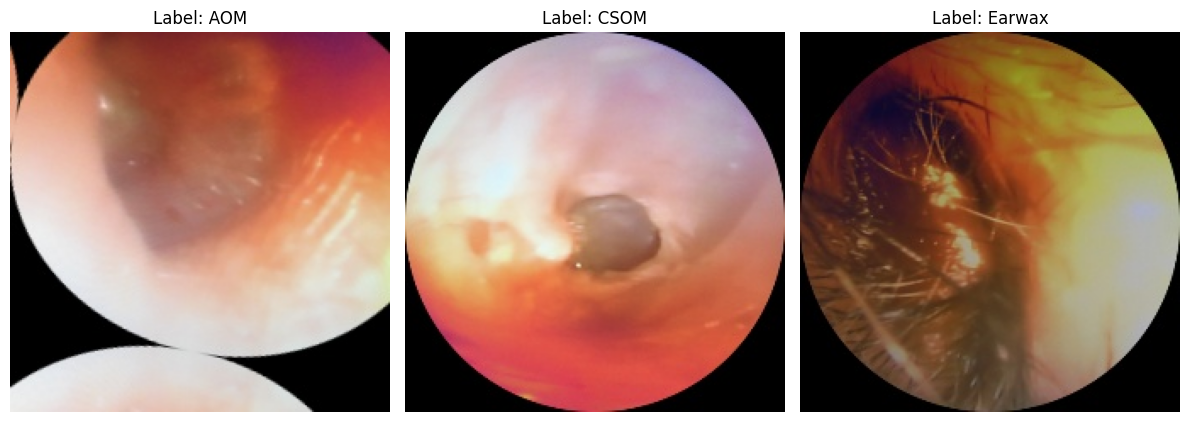

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 증강된 데이터 시각화
class_labels = {1: 'AOM', 2: 'CSOM', 3: 'Earwax'}
samples_per_class = {}

for class_label in augment_counts.keys():
    class_data = augmented_df[augmented_df['label'] == class_label]
    if not class_data.empty:
        samples_per_class[class_label] = class_data.iloc[20]['image_path']

# 이미지 시각화
plt.figure(figsize=(12, 6))

for i, (label, img_path) in enumerate(samples_per_class.items()):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0

    plt.subplot(1, 3, i + 1)
    plt.imshow(img_array)
    plt.title(f"Label: {class_labels[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# tf.data.Dataset 생성 함수 정의
def load_dataset(image_paths, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    def process_path(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0
        return image, tf.one_hot(label, depth=4)
    
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(24)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = load_dataset(train_data['image_path'].values, train_data['label'].values, is_training=True)
val_dataset = load_dataset(test_data['image_path'].values, test_data['label'].values, is_training=False)

2024-07-24 08:32:01.132537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9773 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [11]:
print(len(val_dataset))

8


In [12]:
# # 데이터 확인
# print(train_dataset['label'].value_counts())
# print(val_dataset['label'].value_counts())

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history, epochs_range=None):
    
    if epochs_range is None:
        epochs_range = range(len(history.history['accuracy']))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    
    # Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [14]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_and_visualize_model(model, val_dataset):
    # 모델 예측
    y_pred = []
    y_true = []
    for images, labels in val_dataset:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # Classification Report 출력
    print(classification_report(y_true, y_pred))

    # Confusion Matrix 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# SGDR 학습률 스케줄러 함수 정의
def sgdr_schedule(epoch, lr):
    initial_learning_rate = 1e-3 #le-5?
    min_lr = 1e-6
    max_lr = 1e-3
    steps_per_epoch = 5
    lr_decay = 0.9
    cycle_length = 10
    mult_factor = 2
    
    #learning rate 계산 
    cycle = np.floor(1 + epoch / (2 * cycle_length))
    x = np.abs(epoch / cycle_length - 2 * cycle + 1)
    lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1 - x)) * (lr_decay ** (epoch // cycle_length))
    
    return lr

# LearningRateScheduler 콜백 정의
lr_scheduler = LearningRateScheduler(sgdr_schedule)

# logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
# strategy = tf.distribute.MirroredStrategy(logical_gpus)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Convolutional Block 정의
    def conv_block(x, filters):
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    # Residual Block 정의
    def residual_block(x, filters):
        shortcut = x
        x = Conv2D(filters, (3, 3), padding='same', strides=(1, 1))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters, (3, 3), padding='same', strides=(1, 1))(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.add([x, shortcut])
        x = LeakyReLU()(x)
        return x

    # Channel Attention Module 정의
    def channel_attention(x):
        avg_pool = GlobalAveragePooling2D()(x)
        max_pool = GlobalAveragePooling2D()(x)
        dense_avg = Dense(x.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(avg_pool)
        dense_max = Dense(x.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(max_pool)
        combined = tf.keras.layers.add([dense_avg, dense_max])
        channel_attention = Activation('sigmoid')(combined)
        return tf.keras.layers.multiply([x, channel_attention])

    # Spatial Attention Module 정의
    def spatial_attention(x):
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True) #axis=3
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True) #axis=3
        combined = Concatenate(axis=-1)([avg_pool, max_pool]) #axis=3
        spatial = Conv2D(1, (7, 7), padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(combined)
        permuted_tensor = Permute((3,1,2))(spatial)
        return tf.keras.layers.multiply([x, spatial])

    # CBAM Block 정의
    def cbam_block(x):
        x = channel_attention(x)
        x = spatial_attention(x)
        return x
    
    # Stage 1 정의
    def stage1(input_tensor):
        x = conv_block(input_tensor, 32)
        x = conv_block(x, 32)
        x = MaxPooling2D((2, 2))(x)
        x = UpSampling2D((4, 4), interpolation='bilinear')(x)  
        return x

    # Stage 2 정의
    def stage2(input_tensor):
        x = conv_block(input_tensor, 64)
        x = cbam_block(x)
        x = residual_block(x, 64)
        x = MaxPooling2D((2, 2))(x)
        x = UpSampling2D((4, 4), interpolation='bilinear')(x)  
        return x

    # Stage 3 정의
    def stage3(input_tensor):
        x = conv_block(input_tensor, 128)
        x = cbam_block(x)
        x = residual_block(x, 128)
        x = MaxPooling2D((2, 2))(x)
        x = UpSampling2D((4, 4), interpolation='bilinear')(x)  
        return x

    # 모델 구성
    input_tensor = Input(shape=(224, 224, 3))

    stage1_output = stage1(input_tensor)
    stage2_output = stage2(input_tensor)
    stage3_output = stage3(input_tensor)
    
    # Concatenate 전에 모든 텐서의 크기를 동일하게 맞추기
    #stage1_output = UpSampling2D(size=(4.0, 4.0), interpolation='bilinear')(stage1_output)  
    #stage2_output = UpSampling2D(size=(2.0, 2.0), interpolation='bilinear')(stage2_output) 

    # 필요한 경우 채널 수를 맞추기 위해 Conv2D 사용
    # stage1_output = Conv2D(128, (1, 1), padding='same')(stage1_output)
    # stage2_output = Conv2D(128, (1, 1), padding='same')(stage2_output)

    concatenated = Concatenate()([stage1_output, stage2_output, stage3_output])

    x = GlobalAveragePooling2D()(concatenated)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    # 모델 학습
    checkpoint_filepath = 'PeerJ_checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    # 모델 학습
    history = model.fit(
        train_dataset,
        epochs=100,
        validation_data=val_dataset,
        callbacks=[lr_scheduler, model_checkpoint_callback]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/300


2024-07-24 08:32:01.852665: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1656
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
     

 1/69 [..............................] - ETA: 35:31 - loss: 1.3594 - accuracy: 0.3750

2024-07-24 08:32:35.259475: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-24 08:32:40.673298: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-24 08:32:45.951864: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


69/69 [==============================] - ETA: 0s - loss: 1.4466 - accuracy: 0.2554

2024-07-24 08:33:15.881941: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 171
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

69/69 [==============================] - 76s 654ms/step - loss: 1.4466 - accuracy: 0.2554 - val_loss: 1.3593 - val_accuracy: 0.6199 - lr: 1.0000e-06
Epoch 2/300
69/69 [==============================] - 23s 334ms/step - loss: 1.1624 - accuracy: 0.4891 - val_loss: 1.3379 - val_accuracy: 0.6023 - lr: 1.0090e-04
Epoch 3/300
69/69 [==============================] - 23s 333ms/step - loss: 0.9956 - accuracy: 0.5918 - val_loss: 1.2678 - val_accuracy: 0.6199 - lr: 2.0080e-04
Epoch 4/300
69/69 [==============================] - 23s 332ms/step - loss: 0.9122 - accuracy: 0.6196 - val_loss: 1.3084 - val_accuracy: 0.6199 - lr: 3.0070e-04
Epoch 5/300
69/69 [==============================] - 23s 336ms/step - loss: 0.8880 - accuracy: 0.6365 - val_loss: 1.1976 - val_accuracy: 0.6257 - lr: 4.0060e-04
Epoch 6/300
69/69 [==============================] - 23s 332ms/step - loss: 0.8570 - accuracy: 0.6407 - val_loss: 1.9897 - val_accuracy: 0.1988 - lr: 5.0050e-04
Epoch 7/300
69/69 [===========================

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 32)         0         ['batch_normalization[0][0

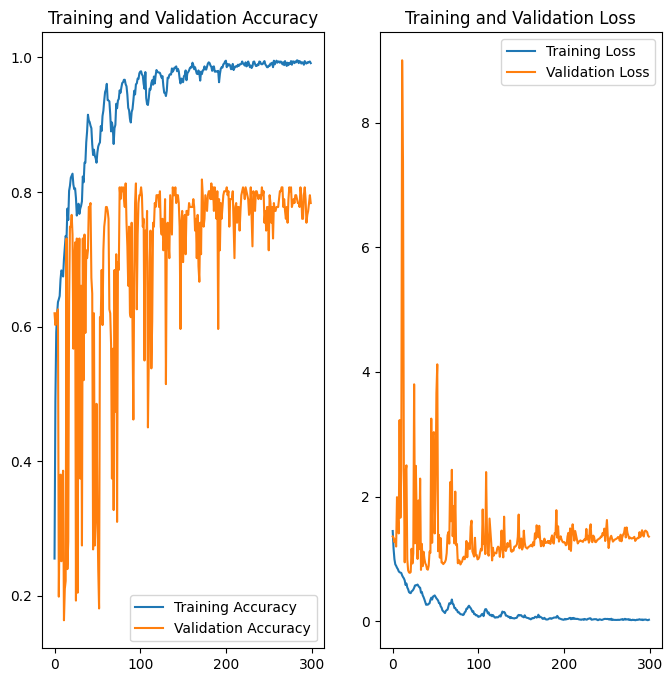

In [17]:
plot_training_history(history, epochs_range=range(100))

1/1 [==============================] - 0s 55ms/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       106
           1       0.53      0.67      0.59        24
           2       0.75      0.46      0.57        13
           3       0.77      0.71      0.74        28

    accuracy                           0.78       171
   macro avg       0.73      0.68      0.69       171
weighted avg       0.79      0.78      0.78       171



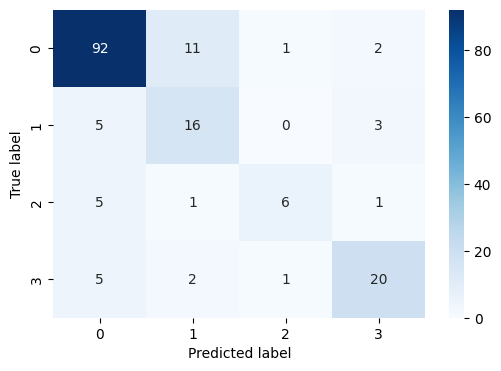

In [18]:
evaluate_and_visualize_model(model, val_dataset)

In [19]:
#model.save('PeerJ_model')

In [20]:
# from tensorflow.keras.models import load_model

# # HDF5 형식의 모델 로드
# model = load_model('PeerJ_model.h5')
# #model = load_model('PeerJ_model') # SavedModel 형식의 모델 로드